In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("ok")

ok


**Helper functions**

In [0]:
from itertools import groupby

import numpy as np
import scipy.sparse as sp


def read_txt(path):
    """read text file from path."""
    with open(path, "r") as f:
        return f.read().splitlines()


def load_data(path_dataset):
    """Load data in text format, one rating per line, as in the kaggle competition."""
    data = read_txt(path_dataset)[1:]
    return preprocess_data(data)


def preprocess_data(data):
    """preprocessing the text data, conversion to numerical array format."""
    def deal_line(line):
        pos, rating = line.split(',')
        row, col = pos.split("_")
        row = row.replace("r", "")
        col = col.replace("c", "")
        return int(row), int(col), float(rating)

    def statistics(data):
        row = set([line[0] for line in data])
        col = set([line[1] for line in data])
        return min(row), max(row), min(col), max(col)

    # parse each line
    data = [deal_line(line) for line in data]

    # do statistics on the dataset.
    min_row, max_row, min_col, max_col = statistics(data)
    print("number of items: {}, number of users: {}".format(max_row, max_col))

    # build rating matrix.
    ratings = sp.lil_matrix((max_row, max_col))
    for row, col, rating in data:
        ratings[row - 1, col - 1] = rating
    return ratings


def group_by(data, index):
    """group list of list by a specific index."""
    sorted_data = sorted(data, key=lambda x: x[index])
    groupby_data = groupby(sorted_data, lambda x: x[index])
    return groupby_data


def build_index_groups(train):
    """build groups for nnz rows and cols."""
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))

    grouped_nz_train_byrow = group_by(nz_train, index=0)
    nz_row_colindices = [(g, np.array([v[1] for v in value]))
                         for g, value in grouped_nz_train_byrow]

    grouped_nz_train_bycol = group_by(nz_train, index=1)
    nz_col_rowindices = [(g, np.array([v[0] for v in value]))
                         for g, value in grouped_nz_train_bycol]
    return nz_train, nz_row_colindices, nz_col_rowindices


def calculate_mse(real_label, prediction):
    """calculate MSE."""
    # the prediction matrix has zero where the real_label has zero
    t = real_label - prediction
    t=t**2 
    sum_squared=t.sum()
    num_nonzero=np.count_nonzero(t)
    
    return (1.0 *sum_squared)/num_nonzero

**Functions for plotting**

In [0]:

def plot_raw_data(ratings):
    """plot the statistics result on raw rating data."""
    # do statistics.
    num_items_per_user = np.array((ratings != 0).sum(axis=0)).flatten()
    num_users_per_item = np.array((ratings != 0).sum(axis=1).T).flatten()
    sorted_num_movies_per_user = np.sort(num_items_per_user)[::-1]
    sorted_num_users_per_movie = np.sort(num_users_per_item)[::-1]

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(sorted_num_movies_per_user, color='blue')
    ax1.set_xlabel("users")
    ax1.set_ylabel("number of ratings (sorted)")
    ax1.grid()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(sorted_num_users_per_movie)
    ax2.set_xlabel("items")
    ax2.set_ylabel("number of ratings (sorted)")
    ax2.set_xticks(np.arange(0, 2000, 300))
    ax2.grid()

    plt.tight_layout()
    plt.savefig("stat_ratings")
    plt.show()
    # plt.close()
    return num_items_per_user, num_users_per_item


def plot_train_test_data(train, test):
    """visualize the train and test data."""
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.spy(train, precision=0.01, markersize=0.5)
    ax1.set_xlabel("Users")
    ax1.set_ylabel("Items")
    ax1.set_title("Training data")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.spy(test, precision=0.01, markersize=0.5)
    ax2.set_xlabel("Users")
    ax2.set_ylabel("Items")
    ax2.set_title("Test data")
    plt.tight_layout()
    plt.savefig("train_test")
    plt.show()

**Data preprocessing and Loading**

Loading and preprocessing data, creating rating matrix, one item per row. The shape of the rating matrix will be (items,users). To facilitate the re-usage of this notebook, I decided to load the data directly from a github raw link, so that other people don't have to donwload the dataset before running everything


In [4]:
url="https://raw.githubusercontent.com/epfml/ML_course/master/labs/ex10/template/movielens100k.csv"
data=pd.read_csv(url)
data.iloc[:,0]=data.iloc[:,0].str.replace("r", "")
data.iloc[:,0]=data.iloc[:,0].str.replace("c","")
new=data.iloc[:,0].str.split("_",expand=True)
data["r"]=new[0]
data["c"]=new[1]

data.drop(columns=["r1_c1"],inplace=True)

data=data[["r","c","5.0"]]

data["r"]=data["r"].astype(int)
data["c"]=data["c"].astype(int)

max_row=data["r"].max()
max_column=data["c"].max()


ratings=np.zeros([max_row,max_column])*np.nan

print(ratings)

data=data.to_numpy().astype(int)

print(data)
for row, column , rating in data:
  ratings[row-1,column-1]=rating
 

ratings
ratings=np.nan_to_num(ratings)

ratings

#rating is in hte form (num items, num users)



[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[   1    2    4]
 [   1    5    4]
 [   1    6    4]
 ...
 [1680  863    2]
 [1681  896    3]
 [1682  916    3]]


array([[0., 4., 0., ..., 5., 0., 0.],
       [3., 0., 0., ..., 0., 0., 5.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We know have a rating matrix with each row being the costumer, each column the movie (item). If the user did not watch the movie, the value is nan

# EXERCICE 1: Splitting data

We're filtering the data to keep only the users who have seen at least 10 movies and the movies that have been seen at least 10 times. Then we split randomly and uniformly to get a test and train datasets.
Note that when spliting, we're punching a hole in the matrix

In [0]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
  #ratings is in the shape (items,users)
  #num_items_per_user is an array that specifies how many movies the user has seen
  #num_users_per_item is an array that specifies how many people have seen this move 
  #all arrays should be numpy array
  
  print("Total number of nonzero elements in origial data:{v}".format(v=np.count_nonzero(ratings)))
  
  np.random.seed(988)
  valid_users=np.where(num_items_per_user >=min_num_ratings)
  valid_items=np.where(num_users_per_item >=min_num_ratings)
  
  valid_users=np.array(valid_users).flatten()
  valid_items=np.array(valid_items).flatten()
  
  #be careful with the tuples
  

  ratings=ratings[valid_items,:][:,valid_users]
  
  # now that we have filtered we can split the dataset. We first create same size matrix, and punch a hole in the data set
  num_rows,num_columns=ratings.shape
  train=np.zeros((num_rows,num_columns))
  test=np.zeros((num_rows,num_columns))
  
  nz_items,nz_users =ratings.nonzero() #returns the indexes for non zero items. If we put them side by side we have pairs of non zero in the rating matrix
  
  for user in set(nz_users):
    row=ratings[:,user].nonzero() #indices of non zero item for this user
    
    row=row[0] #it's a tuple, make it one dimensional
    
    test_rows=np.random.choice(row,size=int(len(row)*p_test)) # we get the indices that we will keep for test matrix
    residual=list(set(row)-set(test_rows)) # rows for training set , just removing the ones from test set
    
    
    test[test_rows,user]=ratings[test_rows,user] #put in the values for test set , rest is sparse
    train[residual,user]=ratings[residual,user] # put in the values for train set, rest is sparse
  
    


 
  
  
  print("Total number of nonzero elements in train data:{v}".format(v=np.count_nonzero(train)))
  print("Total number of nonzero elements in test data:{v}".format(v=np.count_nonzero(test)))

        
        
        
  
  return ratings, train, test
  
    

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88954
Total number of nonzero elements in test data:8998
(1152, 943)


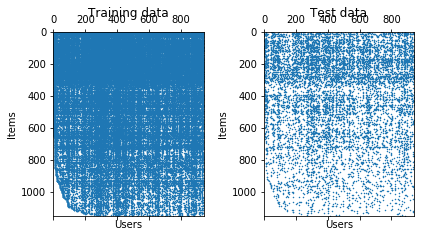

In [6]:
num_items_per_user=[]
num_users_per_item=[]

for row in ratings:
  num_users_per_item.append(np.count_nonzero(row))
num_users_per_item=np.array(num_users_per_item)
  
for column in ratings.T:
  num_items_per_user.append(np.count_nonzero(column))
num_items_per_user=np.array(num_items_per_user)

  
ratings_filtered,train,test=split_data(ratings,num_items_per_user,num_users_per_item,10,0.1)

print(ratings_filtered.shape)

plot_train_test_data(train,test)



# **Exercice 2: Baseline prediction, using means**

We're going to try to predict the rating matrix by using the means per user, means per movie and mean for the entire rating matrix. Since rating is subjective, I hypothesize that the mean per user will be the most effective one

In [0]:
def baseline_global_mean(train,test):
  num_non_zeros= np.count_nonzero(train)
  mean=(1.0/num_non_zeros)*np.sum(train)
  
  predictions=np.zeros(test.shape)
  
  couples_nonzero=test.nonzero() #returns 2 arrays, with the row and column indices that are non zero
  
  
  for idx,row in enumerate(couples_nonzero[0]):
    predictions[row,couples_nonzero[1][idx]]=mean
  
  
  return calculate_mse(test,predictions)
  
  

In [8]:

print("Baseline rmse for global mean is: ",np.sqrt(baseline_global_mean(train,test)))


Baseline rmse for global mean is:  1.1231202910104772


In [0]:
def baseline_user_mean(train,test):
  sums=train.sum(axis=0)
  
  non_zeros=np.count_nonzero(train,axis=0)
  means=sums.astype(float)/non_zeros.astype(float)
  
  
  
  predictions=np.zeros(test.shape)
  couples_nonzero=test.nonzero() #returns 2 arrays, with the row and column indices that are non zero
  
  
  
  for idx,row in enumerate(couples_nonzero[0]):
    predictions[row,couples_nonzero[1][idx]]=means[couples_nonzero[1][idx]]
                                                  
  return calculate_mse(test,predictions)

In [10]:
print("baseline rmse for user mean is: ", np.sqrt(baseline_user_mean(train,test)))


baseline rmse for user mean is:  1.0573147714765376


In [0]:
def baseline_item_mean(train,test):
  
  
  return baseline_user_mean(train.T,test.T)
  
  

In [12]:

print("baseline rmse for item mean is: ", np.sqrt(baseline_item_mean(train,test)))

baseline rmse for item mean is:  1.028610574461298


We can see the the average per item predicts better than average per user. Maybe in general, people have the same opinion about a movie? This is quite surprising
To be more conclusive, we should cross validate

# Exercice 3: Implement matrix factorisation using gradient descent

In [0]:
def init_MF(train,num_features):
  #num_features is the K in the lecture notes
  W=np.random.rand(train.shape[0],num_features)
  Z=np.random.rand(train.shape[1],num_features)
  
  return Z,W

  

In [0]:
def compute_error(data,user_features,item_features):
  # User_features is the Z from init_MF
  # item_features is the W from init_MF
  
  predictions=item_features.dot(user_features.T)
  
  non_zeros=data.nonzero() # returns 1 tuple consisting of 2 arrays, one for the row index and the other for the column index of non zero elements
  
  #we now add the erros for non_zero entries in data
  sum_=0
  for idx,row in enumerate(non_zeros[0]):
    sum_+=(data[row,non_zeros[1][idx]]-predictions[row,non_zeros[1][idx]])**2
  
  return  np.sqrt(0.5*sum_*(1.0/non_zeros[0].shape[0]))
    
    
    
  
  

In [0]:
def matrix_factorization_SGD(train,test):
  # define parameters
  gamma = 0.01
  num_features = 20   # K in the lecture notes
  lambda_user = 0.1
  lambda_item = 0.7
  num_epochs = 20     # number of full passes through the train set
  errors = [0]
    
  # set seed
  np.random.seed(988)

  # init matrix
  user_features, item_features = init_MF(train, num_features)
    
  # find the non-zero ratings indices 
  nz_row, nz_col = train.nonzero()
  nz_train = list(zip(nz_row, nz_col))
  nz_row, nz_col = test.nonzero()
  nz_test = list(zip(nz_row, nz_col))

  print("learn the matrix factorization using SGD...")
  for it in range(num_epochs): 
    # shuffle the training rating indices
    np.random.shuffle(nz_train)
        
    # decrease step size
    gamma /= 1.2
        
    for d, n in nz_train:
      # since nz_train was shuffled, this loop is like randomly selecting, hence SGD
      err=train[d][n]-item_features[d,:].dot(user_features.T[:,n])
      gradient_item_features=err*user_features[n,:]
      gradient_user_features=err*item_features[d,:]
        
      #update for this row
      item_features[d,:]+=gamma*gradient_item_features
      user_features[n,:]+=gamma*gradient_user_features
        
    rmse=compute_error(train,user_features,item_features)
    print("iter: {}, RMSE on training set: {}.".format(it, rmse))   
    errors.append(rmse)
  rmse = compute_error(test, user_features, item_features)
  print("RMSE on test data: {}.".format(rmse)) 
    
  

In [16]:
matrix_factorization_SGD(train,test)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 0.6986086457387838.
iter: 1, RMSE on training set: 0.6643116527621435.
iter: 2, RMSE on training set: 0.6488944465441616.
iter: 3, RMSE on training set: 0.6394451549826354.
iter: 4, RMSE on training set: 0.6328539050442643.
iter: 5, RMSE on training set: 0.6279107148210853.
iter: 6, RMSE on training set: 0.6239232113171198.
iter: 7, RMSE on training set: 0.6208534486985824.
iter: 8, RMSE on training set: 0.6184186146027768.
iter: 9, RMSE on training set: 0.616414398042685.
iter: 10, RMSE on training set: 0.6148048558882357.
iter: 11, RMSE on training set: 0.6134593242836209.
iter: 12, RMSE on training set: 0.6123748767537686.
iter: 13, RMSE on training set: 0.6114669720974553.
iter: 14, RMSE on training set: 0.6107172666728297.
iter: 15, RMSE on training set: 0.6100973132162597.
iter: 16, RMSE on training set: 0.6095784799097271.
iter: 17, RMSE on training set: 0.6091494558889831.
iter: 18, RMSE on training set: